In [120]:
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [121]:
data_dir = 'C://Users//kashkin//Desktop//keithley data//'
current_limit = 1.0e-6
soak_time = 5

In [147]:
experiment_name = 'secondary time series testing'
data_points = 1001
voltage_limit = 3000
measurement_count = 1
measurement_interval = 1.0e-3
input_voltages = list(np.linspace(0, -1000, num=data_points))
measured_voltages = []
measured_currents = []
times = []

In [123]:
### Connect to keithley
rm = pyvisa.ResourceManager()
print(rm.list_resources())
keithley = rm.open_resource('GPIB1::11::INSTR')
print("Using " + keithley.query('*IDN?'))

('TCPIP0::18.25.28.214::inst0::INSTR', 'TCPIP0::18.62.7.104::inst0::INSTR', 'TCPIP0::18.25.28.21::inst0::INSTR', 'TCPIP0::18.25.25.62::inst0::INSTR', 'ASRL1::INSTR', 'GPIB1::11::INSTR')
Using Keithley Instruments Inc., Model 2657A, 4033749, 1.1.8



In [124]:
keithley.write('smua.reset()')

14

In [148]:
# Configure as voltage source
keithley.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_ONCE \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_FAST \n\
    smua.measure.interval = {m_int} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, m_int=measurement_interval))

443

In [159]:
# Iterate through data points
start_time = float(datetime.datetime.now().timestamp())
for voltage in input_voltages:
    keithley.write('smua.source.levelv = %s'%voltage)
    keithley.write("ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)")
    measured_current = float(keithley.query("print(ireading)")[:-1])
    measured_voltage = float(keithley.query("print(vreading)")[:-1])

    measured_currents.append(measured_current)
    measured_voltages.append(measured_voltage)
    times.append(float(datetime.datetime.now().timestamp()) - start_time)


In [160]:
dts = []
for i in range(len(times) - 1):
    dts.append(times[i+1] - times[i])
print(np.average(dts))
print(1/np.average(dts))

0.0011375689808326432
879.0675702743322


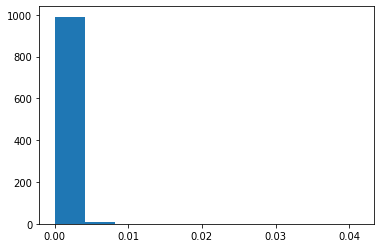

In [128]:
plt.hist(dts)
plt.show()

In [152]:
aggregate_data = {'input_voltages':input_voltages,'measured_voltages':measured_voltages,'measured_currents':measured_currents}

filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//secondary time series testing_ 2022_07_08-16_43_35.json'}


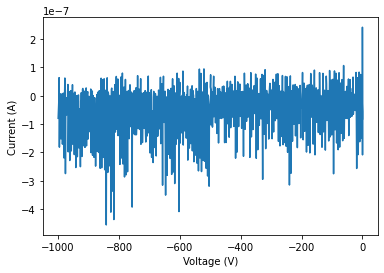

In [161]:
plt.plot(measured_voltages, measured_currents)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.show()

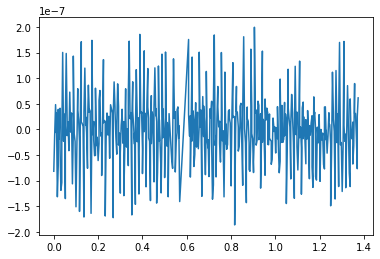

In [162]:
plt.plot(times[:500],measured_currents[:500])
plt.show()

In [163]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
keithley.write("smua.source.levelv = 0")

print("Wait {}s until capacitors are fully discharged".format(soak_time))
time.sleep(soak_time)

print("Turning off output")
keithley.write("smua.source.output = 0")

print("Closing Keithley connection")
keithley.close()


Setting source voltage to 0 V
Wait 5s until capacitors are fully discharged
Turning off output
Closing Keithley connection
